In [38]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [68]:
file1 = '/Users/xierao/Downloads/control_motor.p'
with open(file1, 'rb') as f:
    data = pickle.load(f)
    
file2 = '/Users/xierao/Downloads/control_sensory.p'
with open(file2, 'rb') as f:
    sen = pickle.load(f)
  
print(f'length of motor data: {len(data)}')
print(data[0].keys())
print(f'length of sensory data: {len(sen)}')
print(sen[0].keys())

length of motor data: 36
dict_keys(['fs', 'scale', 'sourceXY', 'goodFrames', 'lengthSkel', 'area', 'perimeter', 'orientation0', 'maxis', 'minxis', 'cmXY', 'headXY', 'tailXY', 'midXY', 'cmSpeed', 'headSpeed', 'tailSpeed', 'midSpeed', 'bodyTheta', 'bodyOmega', 'headTheta', 'headOmega', 'idxCastEvent', 'idxTurnStart', 'idxTurnEnd'])
length of sensory data: 36
dict_keys(['headSens', 'cmSens', 'tailSens', 'midSens', 'headSensDot', 'cmSensDot', 'tailSensDot', 'midSensDot', 'headSensDotNorm', 'cmSensDotNorm', 'tailSensDotNorm', 'midSensDotNorm', 'headGrad', 'cmGrad', 'tailGrad', 'midGrad', 'stimDir', 'bearing'])


### 1. trajectories for each larva

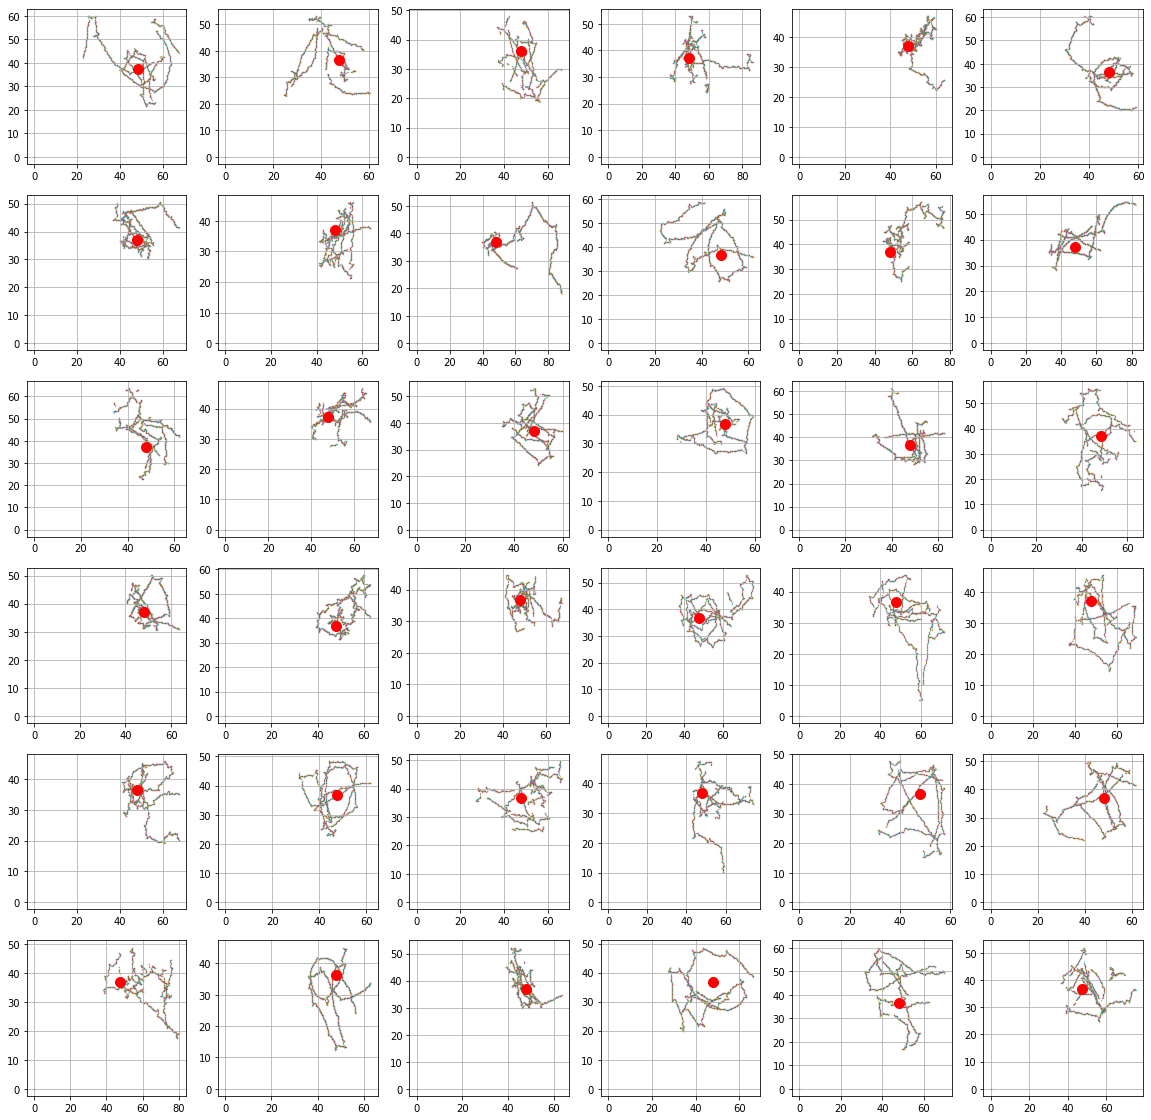

In [7]:
plt.figure(figsize=(20,20))
for i in range(len(data)):
    plt.subplot(6,6,i+1)
    for j in range(len(data[i]['headXY'])):
        plt.scatter(data[i]['headXY'][j][0],data[i]['headXY'][j][1],s=0.1)
    plt.scatter(data[i]['sourceXY'][0],data[i]['sourceXY'][1],s=100,c='r')
    plt.grid()

### 2. zoom-in to one larva and see how many bins do we need
350 bins seems to be a nice resolution

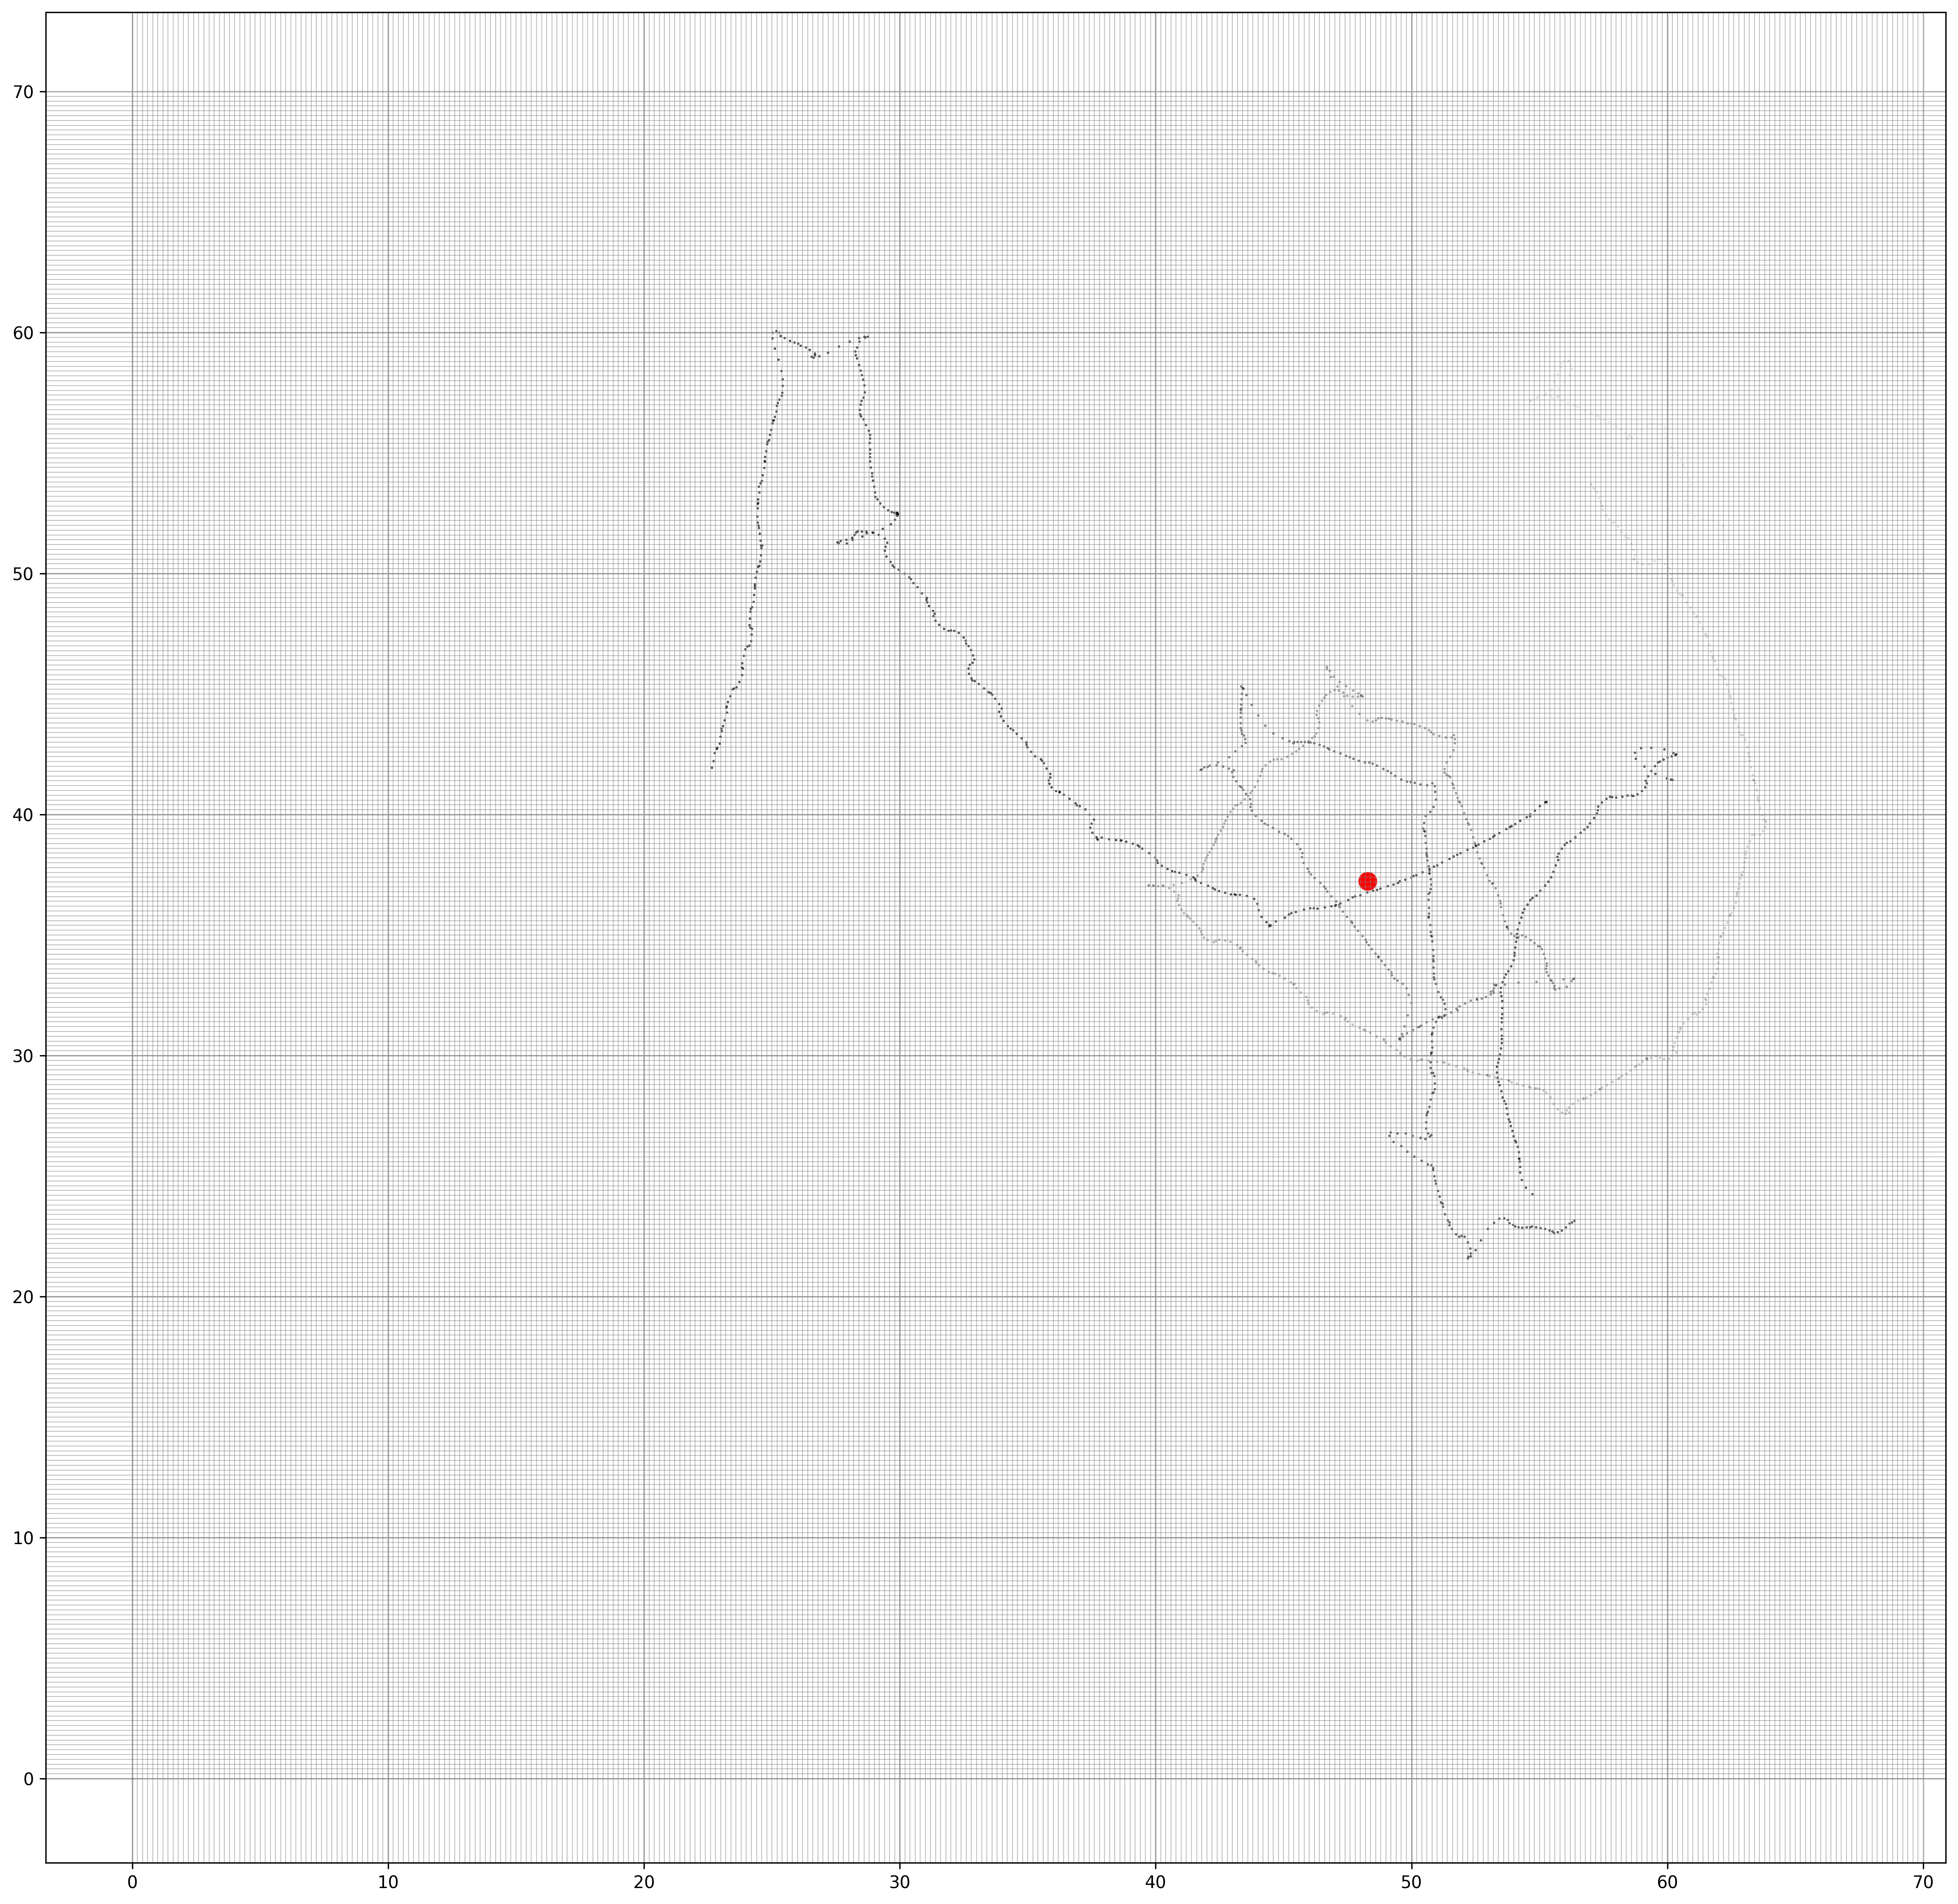

In [15]:
plt.figure(figsize=(20,20), dpi=300)
tmp = 0.01
for j in range(len(data[0]['headXY'])):
    tmp += 0.001
    if tmp>=1:
        tmp=1
    plt.scatter(data[0]['headXY'][j][0],data[0]['headXY'][j][1], c='k', s=0.1, alpha=tmp)
    
plt.scatter(data[0]['sourceXY'][0],data[0]['sourceXY'][1],s=100,c='r')
plt.grid()

for i in range(350):
    plt.axhline(i/5, c='gray', alpha=0.5, linewidth=0.5)
    plt.axvline(i/5, c='gray', alpha=0.5, linewidth=0.5)

### 3. value space
I didn't find data for the gradient defination, only the concentration of the larva's location, so perhaps we need to define a value function ourselves.\
Below I defined a value space according to the distance to the source, and the value spreading according to a Gaussain distribution.\
Black dot is the **source location**\
Yellow dots are **'headSens'** - odor concentration at the head point, value is represented by the color depth

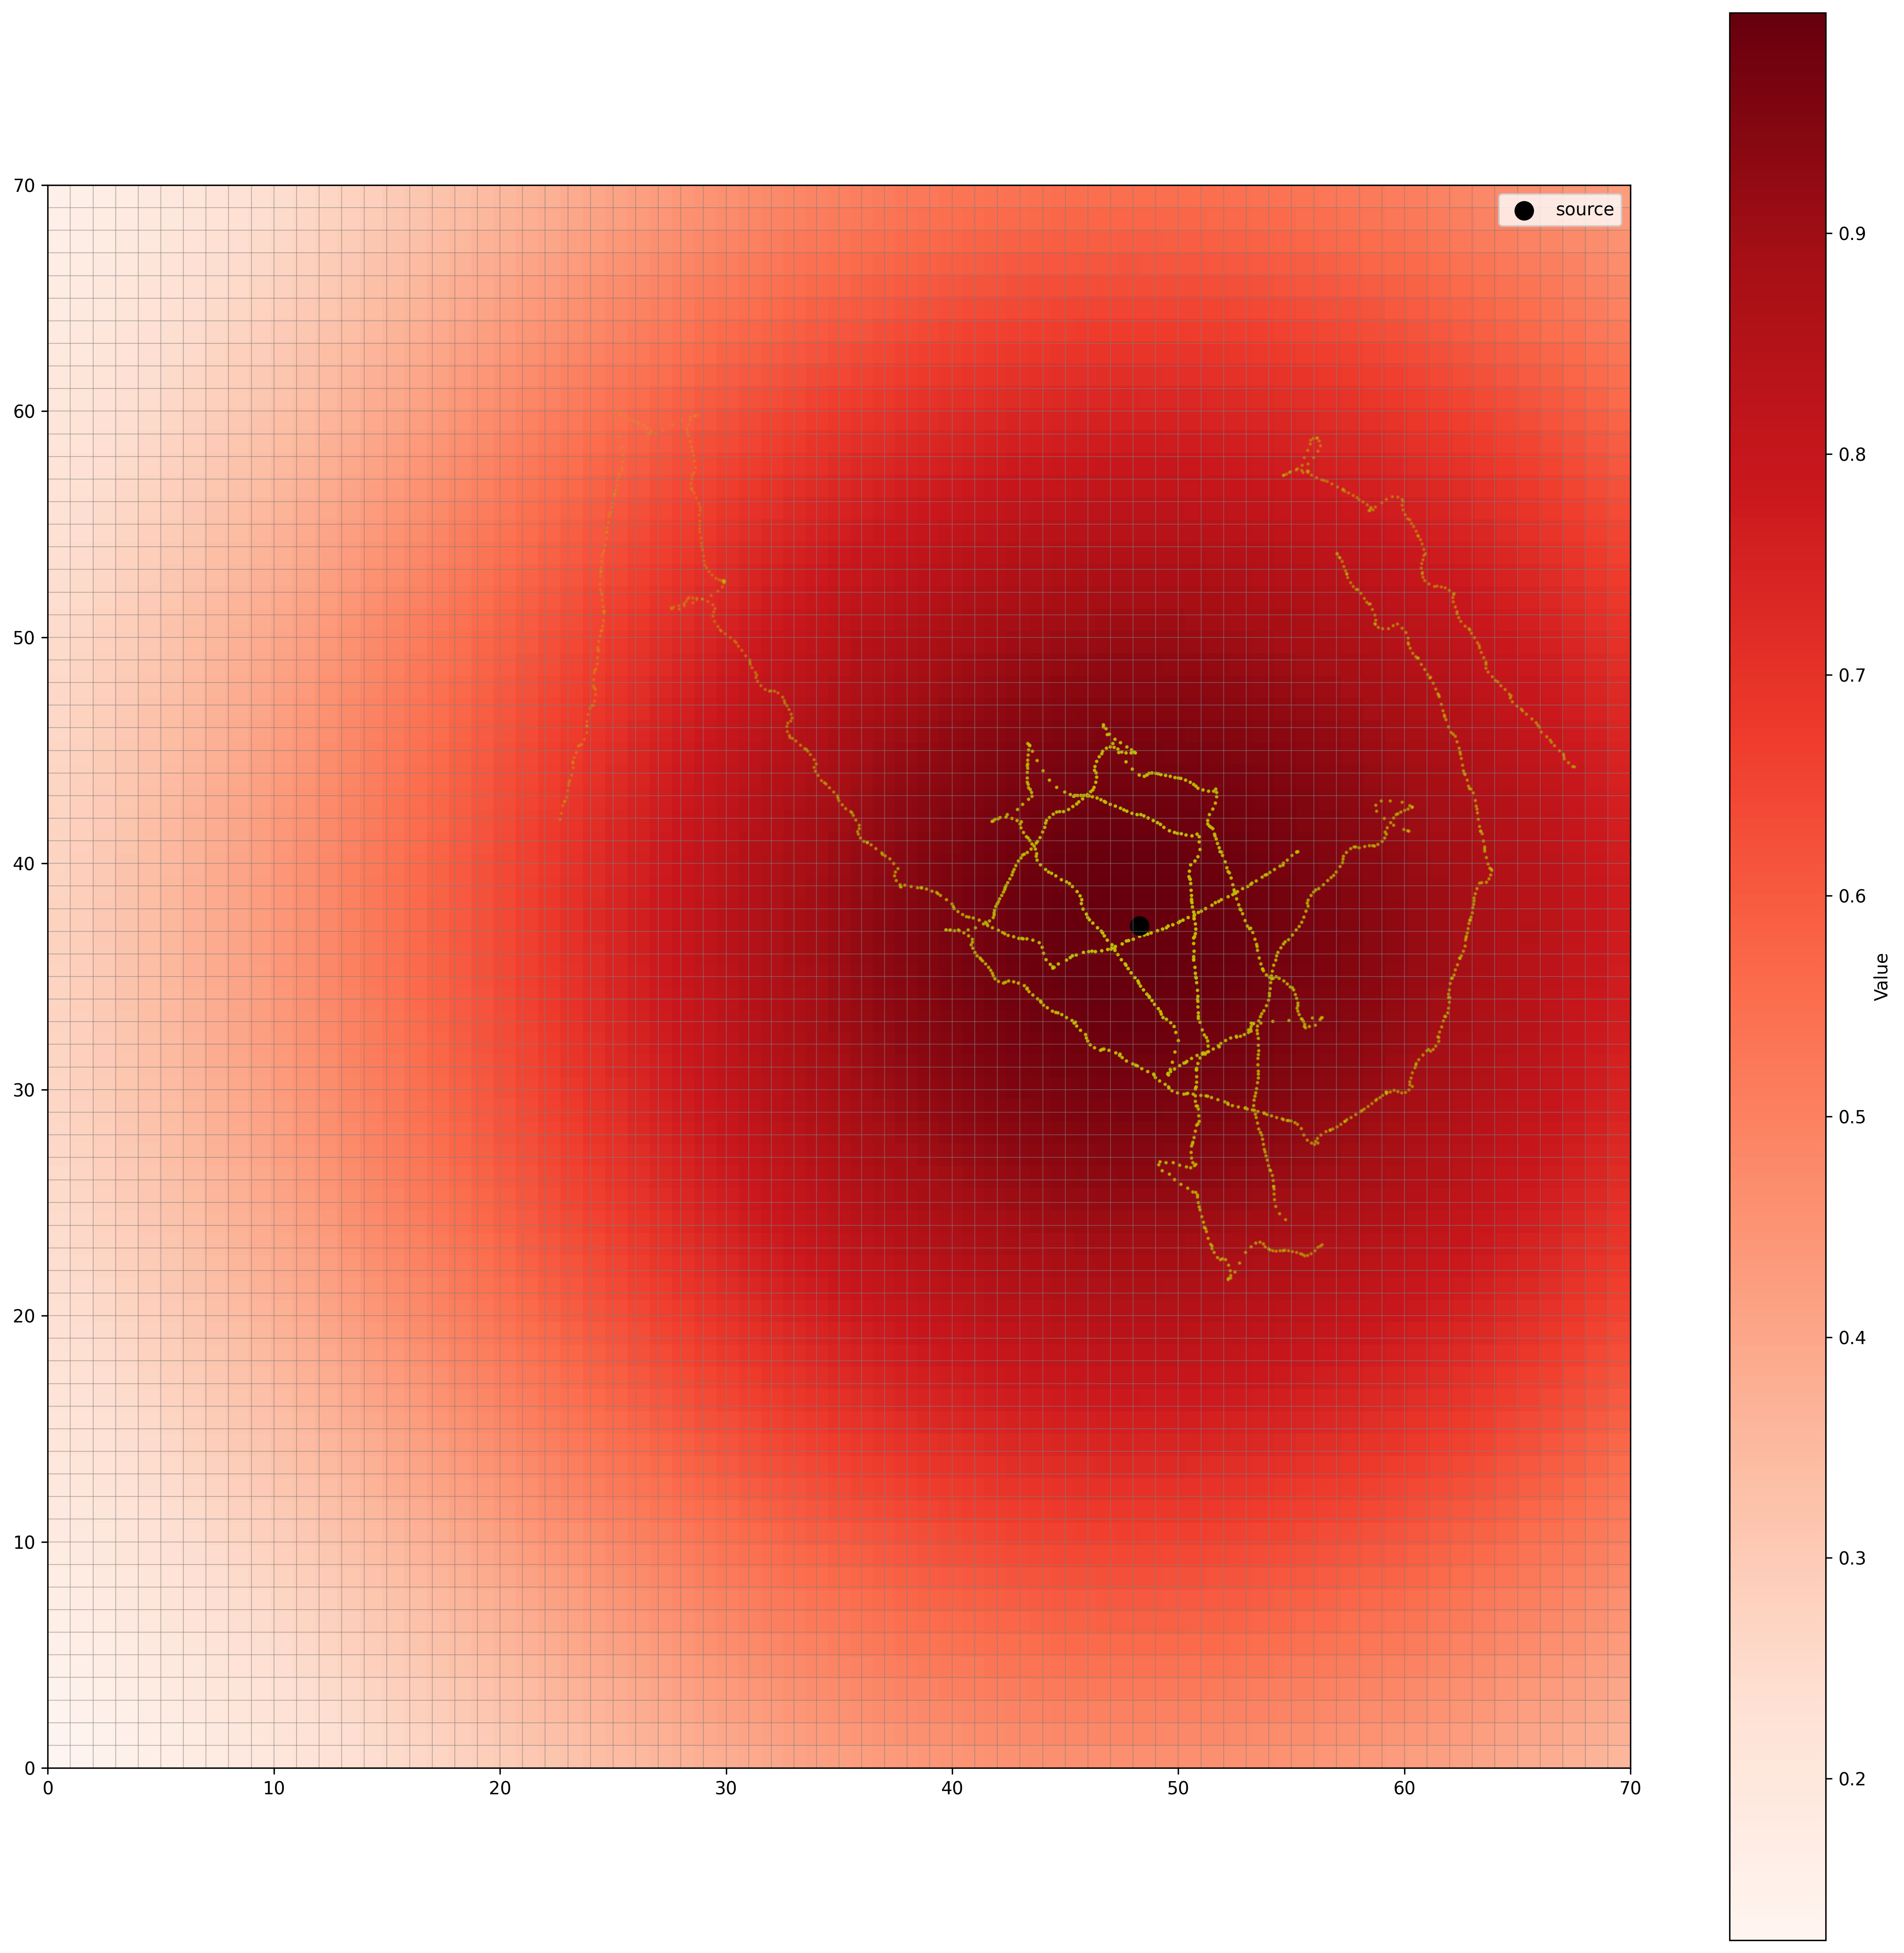

In [53]:
i=0 # the first larva

grid_size = 70
source_x, source_y = data[i]['sourceXY']
x = np.linspace(0, grid_size, grid_size + 1)
y = np.linspace(0, grid_size, grid_size + 1)
X, Y = np.meshgrid(x, y)
distance = np.sqrt((X - source_x)**2 + (Y - source_y)**2)
# Define the value function (Gaussian)
sigma = 30  # Standard deviation controlling the spread
Z = np.exp(-(distance**2) / (2 * sigma**2))
plt.figure(figsize=(20,20), dpi=300)
plt.imshow(Z, extent=(0, grid_size, 0, grid_size), origin='lower', cmap='Reds')
plt.colorbar(label='Value')


sen[i]['headSens'] = [0 if math.isnan(a) else a for a in sen[i]['headSens']]
alpha_values = [v / max(sen[i]['headSens']) for v in sen[i]['headSens']]

for j in range(len(sen[i]['headSens'])):
    plt.scatter(data[i]['headXY'][j][0],data[i]['headXY'][j][1], c='y', s=1, alpha=alpha_values[j])
plt.scatter(data[i]['sourceXY'][0],data[i]['sourceXY'][1],s=100,c='k', label='source')
plt.legend()

for i in range(70):
    plt.axhline(i, c='gray', alpha=0.5, linewidth=0.5)
    plt.axvline(i, c='gray', alpha=0.5, linewidth=0.5)

### 4. head orientation difference between steps

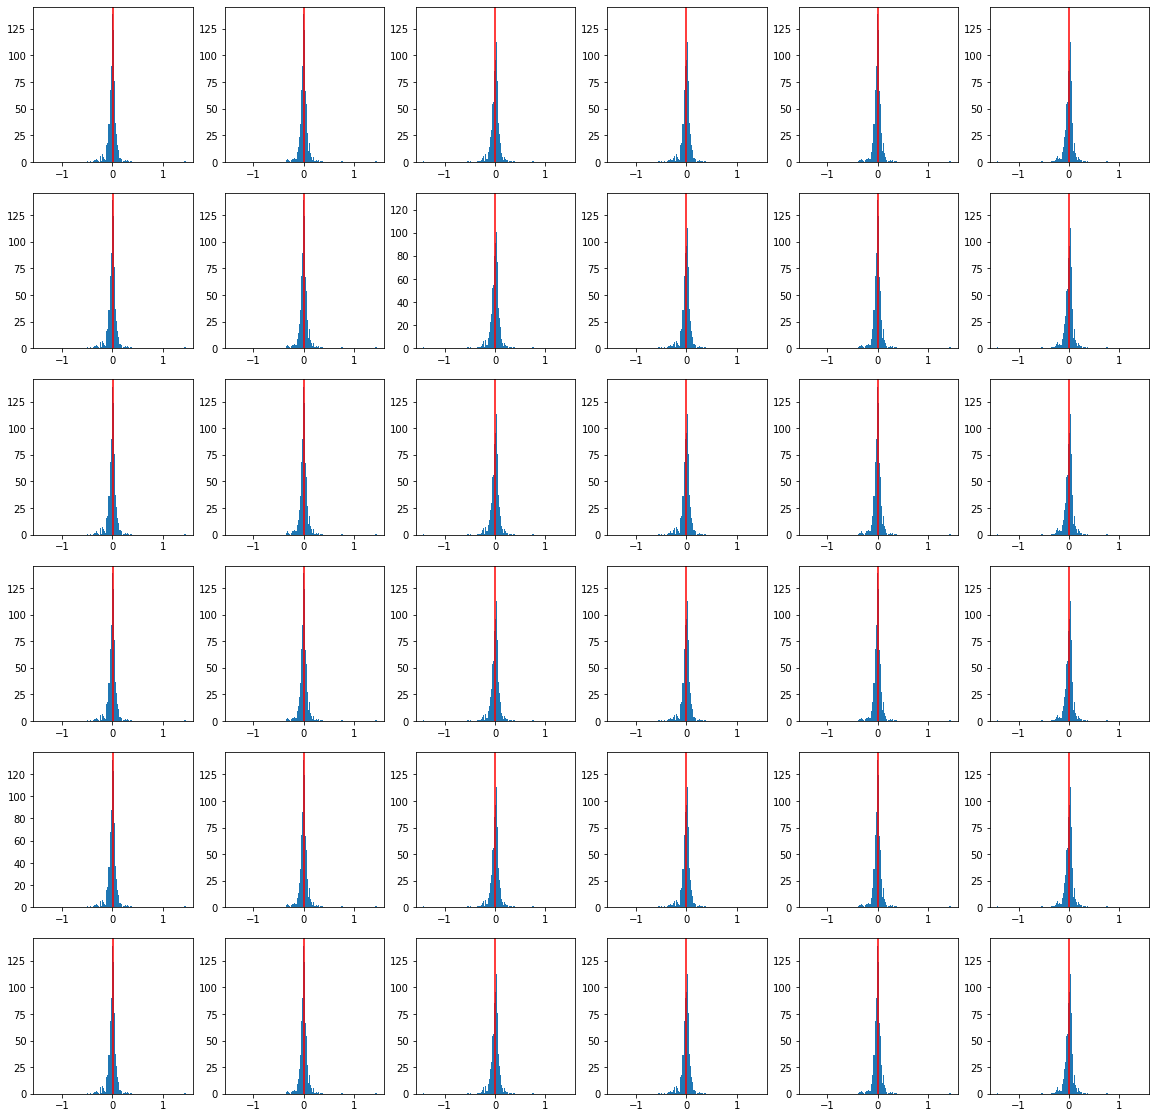

In [14]:
diff_all = []
for i in range(len(data)):
    diff = []
    for j in range(len(data[i]['headTheta'])-1):
        tmp = np.array(data[0]['headTheta'][j+1]) - np.array(data[0]['headTheta'][j])
        diff.append(tmp)
    diff_all.append(diff)

plt.figure(figsize=(20,20))
for i in range(len(data)):
    plt.subplot(6,6,i+1)
    tmp = diff_all[i]
    med = np.median(tmp)
    # tmp = np.array(diff_all[1])[np.array(diff_all[1]) < 60]
    plt.hist(tmp, bins=300)
    plt.axvline(med, color='r')

### 5. map head orientation to action 

In [92]:
magnitude[0:20]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.07319347e+01, 7.15721548e-02, 2.48435757e-01, 2.66640046e-01,
       1.08870398e-01, 9.58463172e-02, 2.29314724e-01, 3.19498932e-01,
       2.03505084e-01, 1.09662247e-01, 2.14145235e-01, 3.08305613e-01,
       2.36181430e-01, 1.14413430e-01, 1.37022862e-01, 2.45535268e-01])

/var/folders/fq/ctr3yzss13b0ry11rh2qmzxc0000gn/T/ipykernel_10529/1745826596.py:20: RuntimeWarning: invalid value encountered in true_divide
  U = direction[:,0] / magnitude /10
/var/folders/fq/ctr3yzss13b0ry11rh2qmzxc0000gn/T/ipykernel_10529/1745826596.py:21: RuntimeWarning: invalid value encountered in true_divide
  V = direction[:,1] / magnitude /10


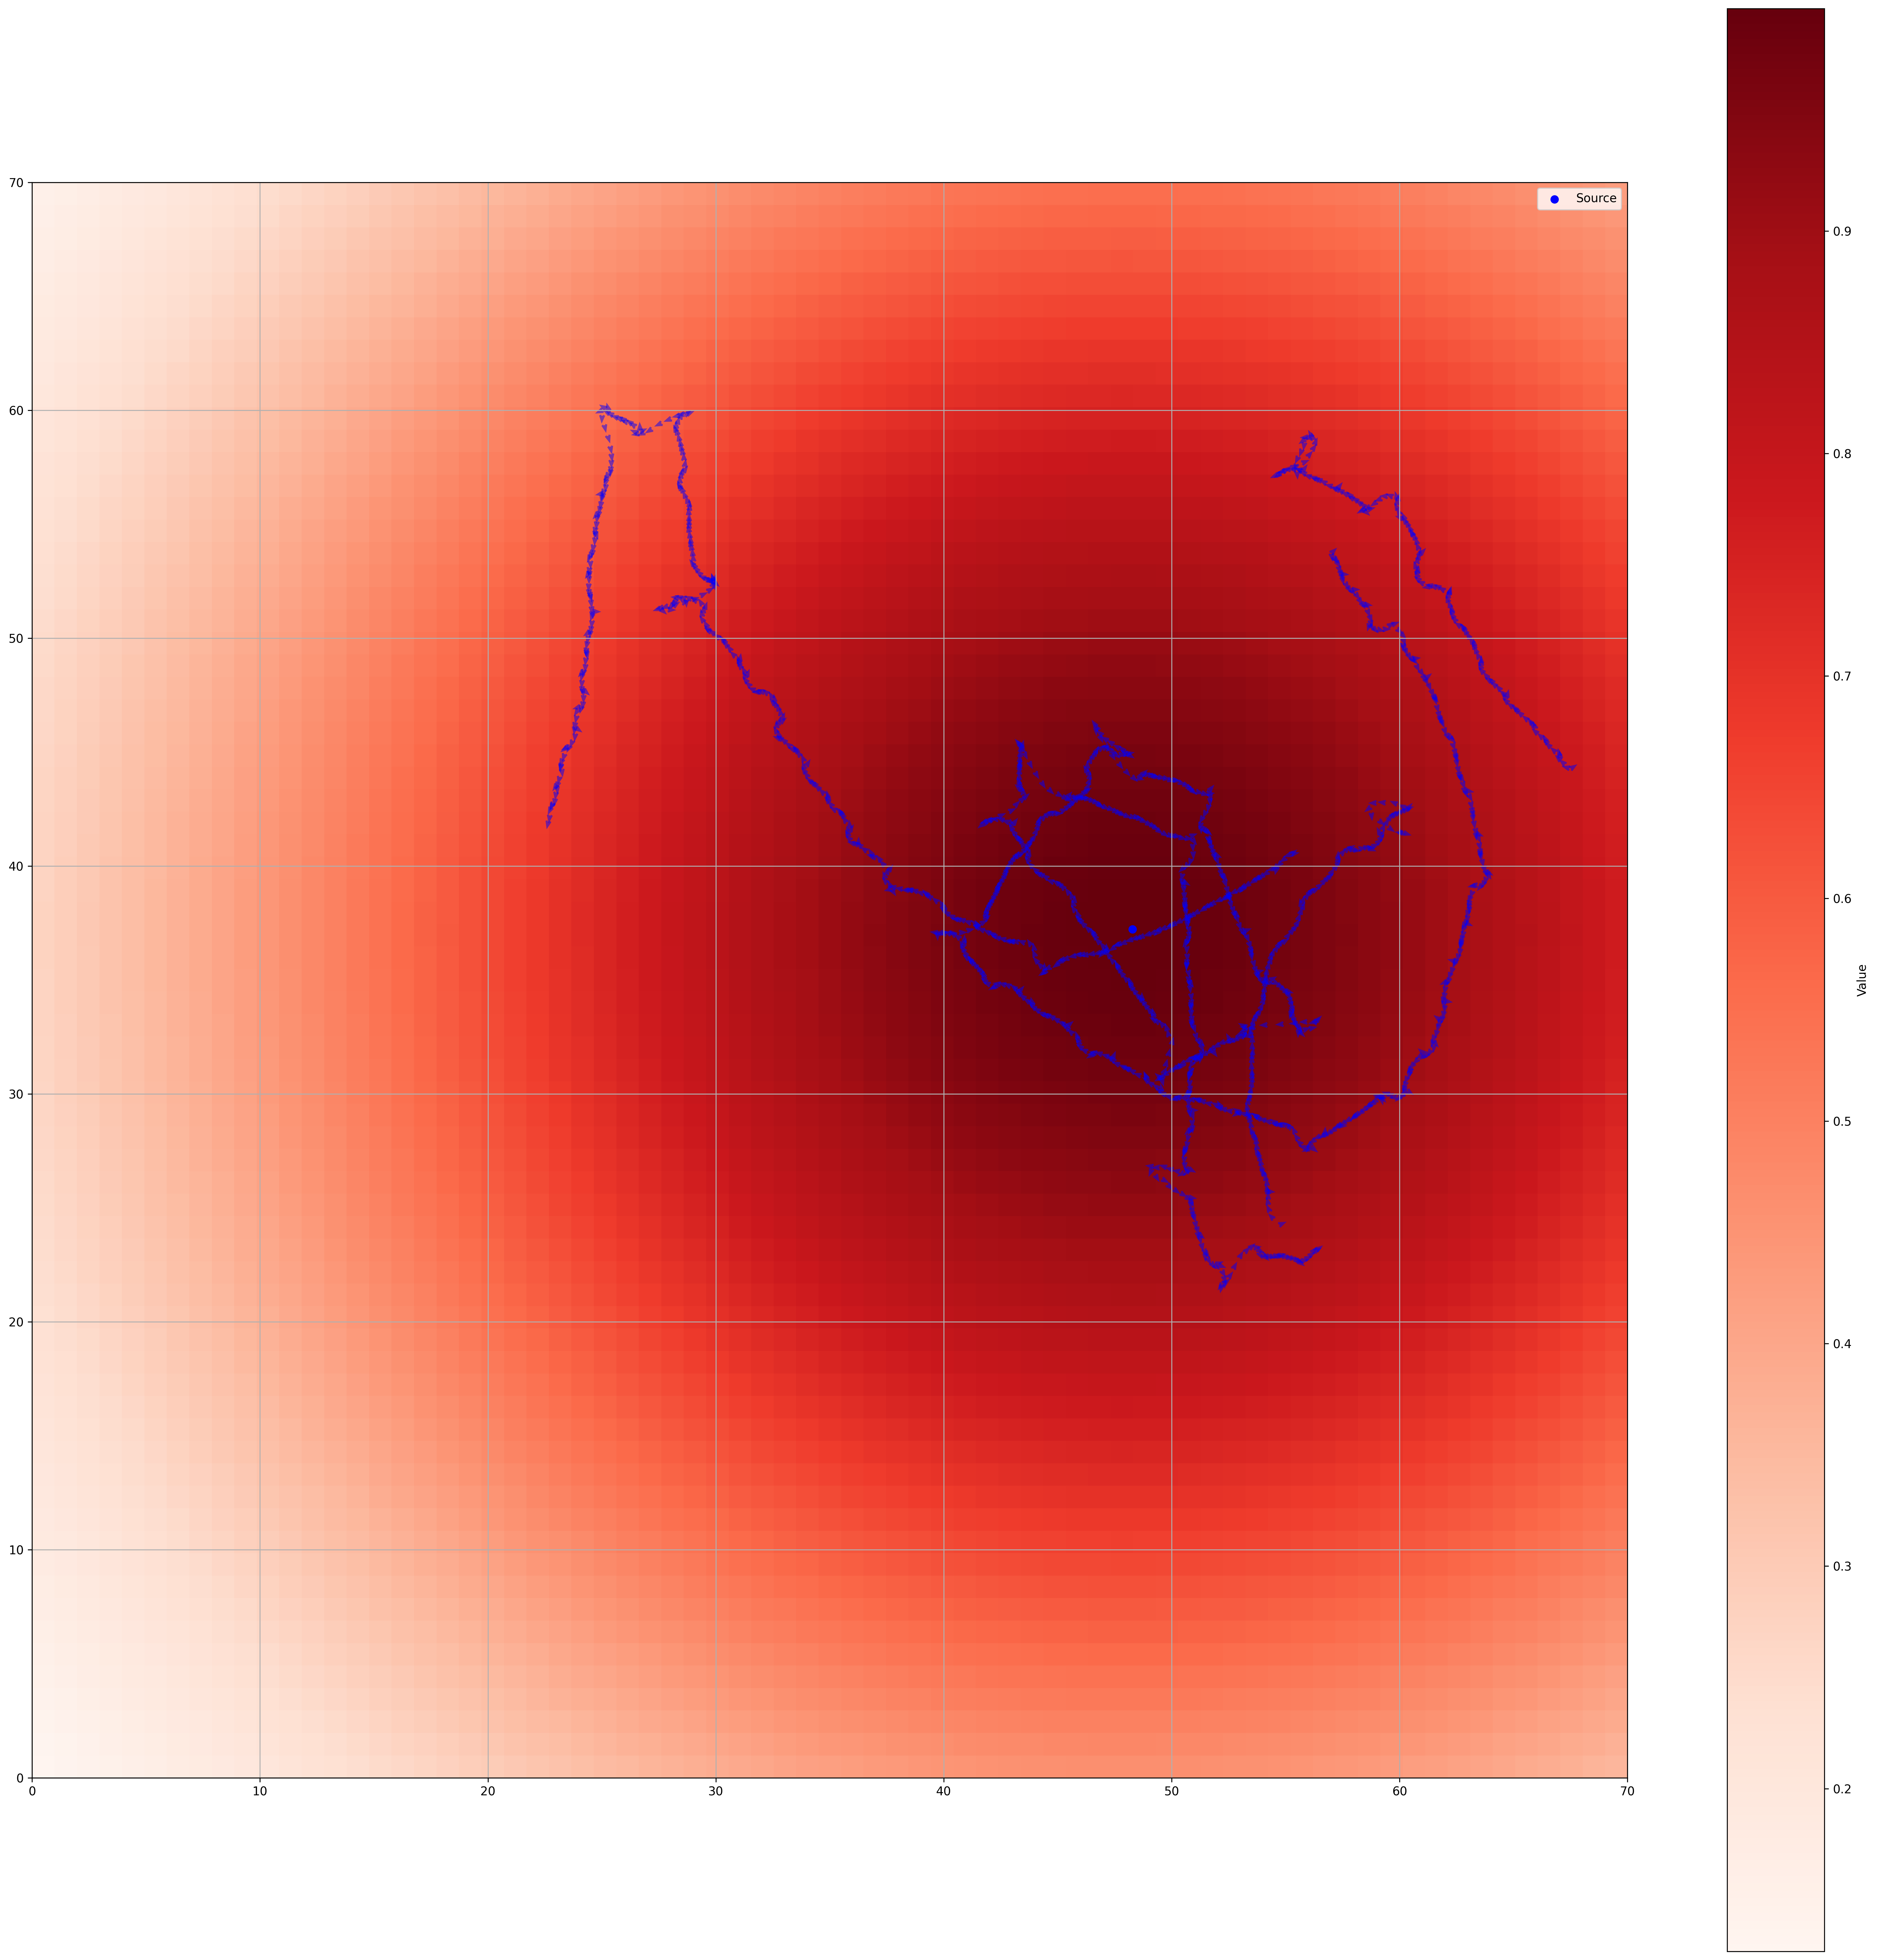

In [102]:
i=0 # the first larva

grid_size = 70
source_x, source_y = data[i]['sourceXY']
x = np.linspace(0, grid_size, grid_size + 1)
y = np.linspace(0, grid_size, grid_size + 1)
X, Y = np.meshgrid(x, y)
distance = np.sqrt((X - source_x)**2 + (Y - source_y)**2)
# Define the value function (Gaussian)
sigma = 30  # Standard deviation controlling the spread
Z = np.exp(-(distance**2) / (2 * sigma**2))


# Calculate directions using array slicing and list comprehension
direction = [np.array(data[i]['headXY'][k+1]) - np.array(data[i]['headXY'][k]) for k in range(len(data[i]['headXY']) - 1)]
direction = np.array(direction)

# Normalize the vectors
magnitude = np.sqrt(direction[:,0]**2 + direction[:,1]**2)
U = direction[:,0] / magnitude /10
V = direction[:,1] / magnitude /10
XX = np.array(data[i]['headXY'])[:,0]
YY = np.array(data[i]['headXY'])[:,1]

# Plot the heatmap using the 'Reds' color palette
plt.figure(figsize=(30,30), dpi=300)
plt.imshow(Z, extent=(0, grid_size, 0, grid_size), origin='lower', cmap='Reds')
plt.colorbar(label='Value')
plt.scatter(source_x, source_y, color='blue', label='Source')
# plt.quiver(XX[1:], YY[1:], U, V, color='blue', alpha=0.5)
plt.quiver(XX[1:], YY[1:], U, V, color='blue', alpha=0.5, scale=20, headwidth=3, headlength=4)
plt.legend()
plt.grid(True)
plt.show()
